In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv")

### Feature encoding

In [3]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of label Encoder
le = LabelEncoder()

# Using .fit_transform function to fit label and return encoded label
label = le.fit_transform(df['type'])

# removing the column 'type' from df as it is of no use now.
df.drop("type", axis=1, inplace=True)

# Appending the array to our dataFrame with column name 'type'
df["type"] = label

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['nameDest'])
label
df.drop("nameDest", axis=1, inplace=True)
df["nameDest"] = label

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['nameOrig'])
label
df.drop("nameOrig", axis=1, inplace=True)
df["nameOrig"] = label

### Stratified train-test split

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
# Separate the target variable
y = df['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=18)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998709
1    0.001291
Name: isFraud, dtype: float64
0    0.998709
1    0.001291
Name: isFraud, dtype: float64
0    0.99871
1    0.00129
Name: isFraud, dtype: float64


In [7]:
# Print shape of train and test sets
print("Train set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Test set shape (X_test, y_test):", X_test.shape, y_test.shape)

Train set shape (X_train, y_train): (5726358, 10) (5726358,)
Test set shape (X_test, y_test): (636262, 10) (636262,)


## Handle outliers in train set

In [8]:
import random
random.seed (11)
import numpy as np
from scipy import stats

# Specify columns with outliers
cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Specify the number of bootstrapped samples to create per column
num_samples = 150

# Specify the right trimming proportions for each column
trim_props = {'amount': 0.2, 'oldbalanceOrg': 0.17, 'newbalanceOrig': 0.17, 'oldbalanceDest': 0.2, 'newbalanceDest': 0.2}

# Initialize empty dictionaries to store the trimmed means for each column
train_trimmed_means = {}

# Loop over the specified columns
for col_name in cols_with_outliers:
    
    # Check if the trimming proportion for this column is 0
    if trim_props[col_name] == 0:
        # If so, skip this column and move on to the next one
        continue
    
    # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
    train_bootstrapped_samples = []
    train_trimmed_means_list = []
    
    # Loop over the number of desired samples
    for i in range(num_samples):
        # Randomly select indices from the column in the training set
        train_sample_indices = np.random.choice(X_train.index, size=len(X_train), replace=True)
        
        # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
        train_sample = X_train.loc[train_sample_indices, col_name]
        
        # Append the bootstrapped samples to the list for the training set
        train_bootstrapped_samples.append(train_sample)
        
        # Calculate the right trimmed mean of the bootstrapped sample for the training set
        train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
        train_trimmed_means_list.append(train_right_trimmed_mean)
        
    # Calculate the mean of the right trimmed means for the training set and add it to the dictionary
    train_trimmed_means[col_name] = np.mean(train_trimmed_means_list)

    # Replace the outliers in the training set with the trimmed means
    X_train.loc[X_train[col_name] > np.percentile(X_train[col_name], 100*(1-trim_props[col_name])), col_name] = train_trimmed_means[col_name]

# Print the trimmed means for each column separately for the training set
print("Train set trimmed means: ", train_trimmed_means)

Train set trimmed means:  {'amount': 69987.56858252172, 'oldbalanceOrg': 32091.946272980906, 'newbalanceOrig': 33067.2706599334, 'oldbalanceDest': 217076.3816581426, 'newbalanceDest': 274677.5737412968}


In [9]:
from scipy.stats import skew
skewness = skew(X_train.amount)
print(skewness)
skewness = skew(X_train.oldbalanceOrg)
print(skewness)
skewness = skew(X_train.newbalanceOrig)
print(skewness)
skewness = skew(X_train.oldbalanceDest)
print(skewness)
skewness = skew(X_train.newbalanceDest)
print(skewness)

0.9899090967437568
2.593030756162679
2.68031188689428
1.7592713179876078
1.6082395531221454


### Feature Selection

## Ridge regression

On the other hand, some feature selection methods, such as those based on linear models or distance-based algorithms, may require standardization to ensure that all features contribute equally and to prevent the influence of any one feature dominating the selection process

In [10]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

# Assuming X_train is your feature matrix and y_train is your target variable
# Standardize the feature matrix
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

# Initialize the RidgeCV model
model = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)

# Fit the model to the standardized feature matrix and target variable
model.fit(X_train_std, y_train)

# Print the best alpha value
print("Best alpha:", model.alpha_)

# Print the coefficients of the selected features along with their names
for feature_name, coefficient in zip(X_train.columns, model.coef_):
    print(feature_name, "coefficient:", coefficient)

Best alpha: 10.0
step coefficient: 0.0011168303262022337
amount coefficient: 0.0003063077237376129
oldbalanceOrg coefficient: 0.0014318092233422137
newbalanceOrig coefficient: -0.0011114595313547505
oldbalanceDest coefficient: -0.0005201754489544707
newbalanceDest coefficient: -0.00043854823557378805
isFlaggedFraud coefficient: 0.001550141422050343
type coefficient: 0.0015938272654626652
nameDest coefficient: -0.0020409619319026982
nameOrig coefficient: -2.1195256158545174e-05


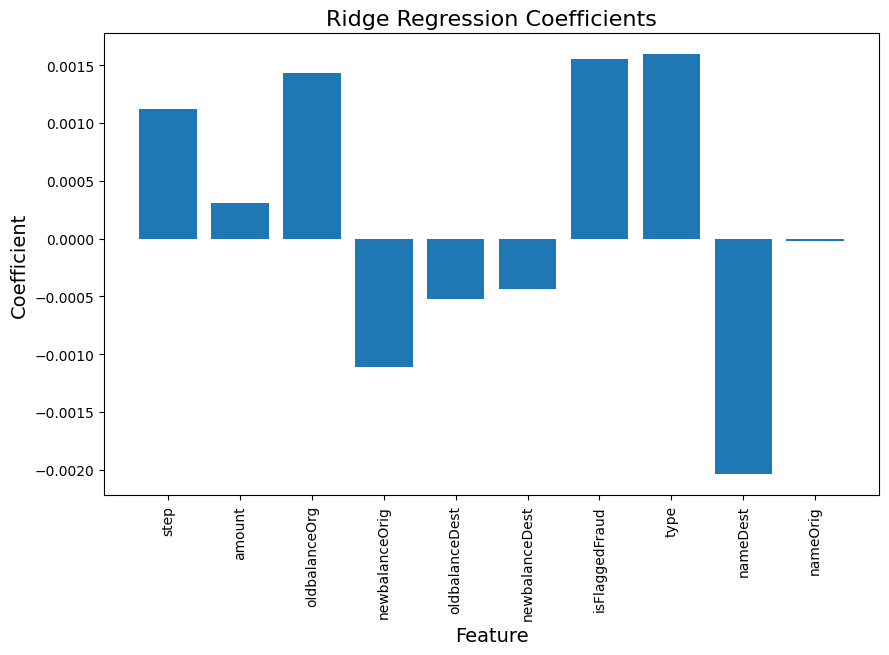

In [11]:
import matplotlib.pyplot as plt

# Create a bar chart of feature coefficients
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(X_train.columns, model.coef_)

# Set chart title and axis labels
ax.set_title("Ridge Regression Coefficients", fontsize=16)
ax.set_xlabel("Feature", fontsize=14)
ax.set_ylabel("Coefficient", fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the chart
plt.show()